# CNA-Protein

In the previous chapters, we investigated the presence of novel or variant peptides in Breast cancer tumors as done by Johansson _et al._ [(2)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references) using a proteogenomic search strategy. Here, we look at the effect of copy number alteration (CNA). Copy number variation is associated with increased or decreased gene expression, but the association with protein abundances is less pronounced, one says that the effect of CNAs is post-translationally attenuated [(2,3)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references).

##### 💬 In you opinion, what mechanisms can affect the association between CNA, gene expression, and protein abundances?


## Libraries

We will need the following libraries, please make sure that they are installed.

In [4]:
install.packages("conflicted")

library(conflicted)
library(tidyr)
library(dplyr)
library(ggplot2)
library(scico)
library(gtable)
library(grid)
library(mclust)
library(igraph)

conflict_prefer("filter", "dplyr")

theme_set(theme_bw(base_size = 11))

Package 'mclust' version 5.4.5
Type 'citation("mclust")' for citing this R package in publications.
[conflicted] Will prefer dplyr::filter over any other package


## CNA - RNA - Protein abundance relationship

Johansson _et al._ [(2)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references) conduct a correlation analysis similar to Gonçalves _et al._ [(3)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references), where the correlation of protein abundances with CNA is compared to the correlation of RNA levels with CNA. These values are provided in [Supplementary Table 5](../resources/Johansson_et_al_breast_cancer_quantitative_proteome_and_proteogenomic_landscape). The correlation values were extracted in R-friendly format and are availabe in [resources/data/cna-rna-protein](resources/data/cna-rna-protein).

##### 👨‍💻 Import the correlation results.

In [8]:
# Load the file, select the columns of interest, format the columns and content

cnaCorDF <- read.table(
    file = "resources/data/cna-rna-protein",
    header = T,
    sep = "\t",
    comment.char = "",
    quote = "",
    stringsAsFactors = F
)

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#what-do-the-columns-represent-what-is-the-difference-between-pearson-and-spearman-correlations) What do the columns represent? What is the difference between Pearson and Spearman correlations?

##### 👨‍💻 Plot the correlation results for proteins against mRNA as in Figure 6 of Johansson _et al._ [(1)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references) and Figure 1 of Gonçalves _et al._ [(3)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references).

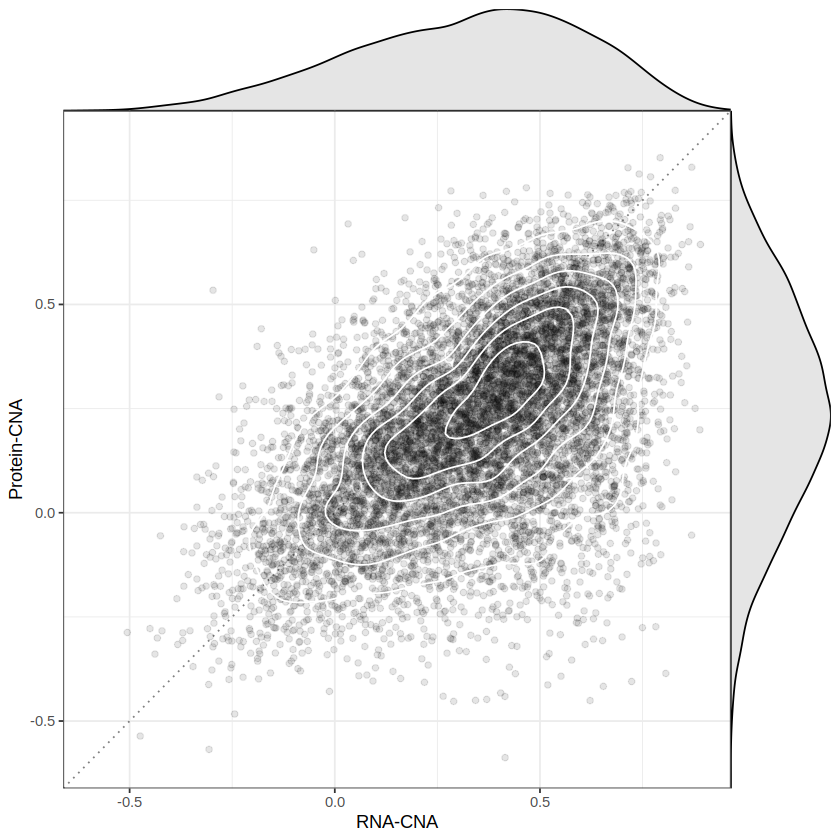

In [9]:
# Build the scatter plot

axisMin <- min(c(cnaCorDF$mRNA_Spearman_correlation, cnaCorDF$protein_Spearman_correlation))
axisMax <- max(c(cnaCorDF$mRNA_Spearman_correlation, cnaCorDF$protein_Spearman_correlation))

scatterPlot <- ggplot(
    data = cnaCorDF
) +
    geom_abline(
        slope = 1,
        intercept = 0,
        linetype = "dotted",
        col = "black",
        alpha = 0.5
    ) +
    geom_point(
        mapping = aes(
            x = mRNA_Spearman_correlation,
            y = protein_Spearman_correlation
        ),
        col = "black",
        alpha = 0.1
    ) +
    geom_density_2d(
        mapping = aes(
            x = mRNA_Spearman_correlation,
            y = protein_Spearman_correlation
        ),
        col = "white",
    ) +
    scale_x_continuous(
        name = "RNA-CNA",
        limits = c(axisMin, axisMax)
    ) +
    scale_y_continuous(
        name = "Protein-CNA",
        limits = c(axisMin, axisMax)
    ) +
    theme(
        legend.position = "none"
    )


# Build the density plots

rnaDensityPlot <- ggplot(
    data = cnaCorDF
) + theme_minimal() + 
    geom_density(
        mapping = aes(
            x = mRNA_Spearman_correlation
        ),
        fill = "black",
        alpha = 0.1
    ) +
    scale_x_continuous(
        expand = c(0, 0)
    ) +
    scale_y_continuous(
        expand = c(0, 0)
    ) +
    theme(
        axis.title = element_blank(),
        axis.text = element_blank(),
        panel.grid = element_blank()
    )

proteinDensityPlot <- ggplot(
    data = cnaCorDF
) + theme_minimal() + 
    geom_density(
        mapping = aes(
            x = protein_Spearman_correlation
        ),
        fill = "black",
        alpha = 0.1
    ) +
    scale_x_continuous(
        expand = c(0, 0)
    ) +
    scale_y_continuous(
        expand = c(0, 0)
    ) +
    theme(
        axis.title = element_blank(),
        axis.text = element_blank(),
        panel.grid = element_blank()
    ) + 
    coord_flip()


# Make grobs from plots

scatterGrob <- ggplotGrob(scatterPlot)
rnaDensityGrob <- ggplotGrob(rnaDensityPlot)
proteinDensityGrob <- ggplotGrob(proteinDensityPlot)


# Insert the densities as new row and column in the scatter grob

mergedGrob <- rbind(scatterGrob[1:6, ], rnaDensityGrob[7, ], scatterGrob[7:nrow(scatterGrob), ], size = "last")
mergedGrob$heights[7] <- unit(0.15, "null")

proteinDensityGrob <- gtable_add_rows(
    x = proteinDensityGrob, 
    heights = unit(rep(0, nrow(mergedGrob) - nrow(proteinDensityGrob)), "null"), 
    pos = 0
)

mergedGrob <- cbind(mergedGrob[, 1:5], proteinDensityGrob[, 5], mergedGrob[, 6:ncol(mergedGrob)], size = "first")
mergedGrob$widths[6] <- unit(0.15, "null")


# Plot

grid.draw(mergedGrob)

##### 💬 How can we categorize CNAs in tumors based on this plot?


Gonçalves _et al._ [(3)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references) define the attenuation coefficient as the difference between the correlation of the transcript and protein levels with the CNA, where a positive and negative coefficient indicate a lower and higher correlation at the protein level, respectively.

##### 👨‍💻 Estimate the attenuation coefficient and plot its density.

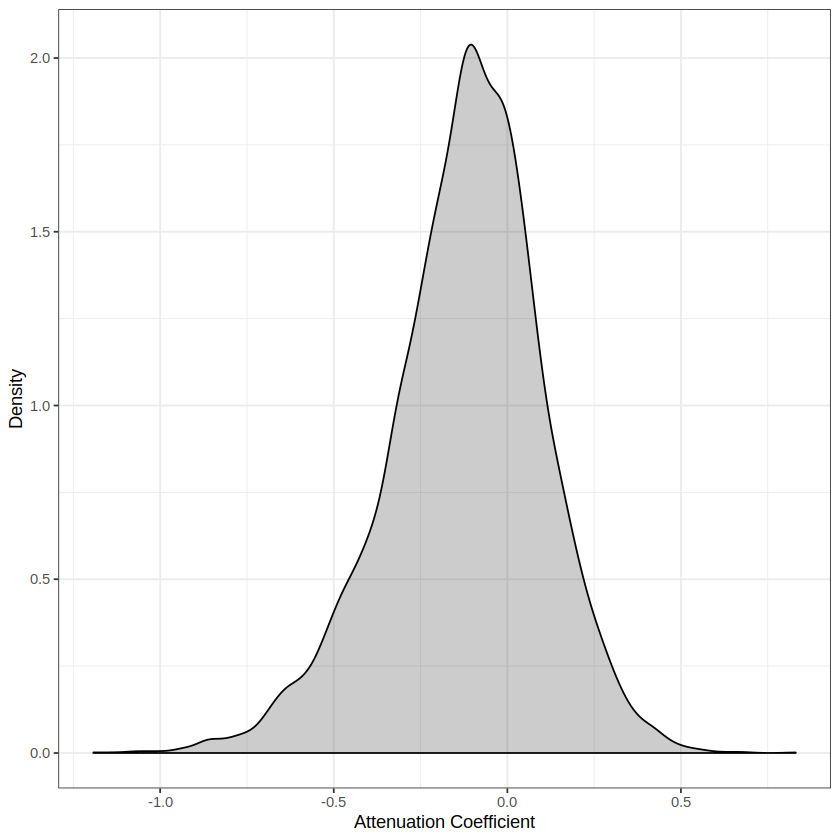

In [10]:
# Attenuation coefficient

cnaCorDF <- cnaCorDF %>%
    mutate(
        attenuation_coefficient = protein_Spearman_correlation - mRNA_Spearman_correlation
    )


# Build density plot

ggplot(
    data = cnaCorDF
) +
    geom_density(
        mapping = aes(
            x = attenuation_coefficient
        ),
        fill = "black",
        alpha = 0.2
    ) +
    scale_x_continuous(
        name = "Attenuation Coefficient"
    ) +
    scale_y_continuous(
        name = "Density"
    )

The authors suggest that this distribution is the combination of two populations of CNAs: post-translationally attenuated and not. They model the distributions of the two populations using Gaussian mixture modelling, where the overall density is decomposed into the sum of densities from Gaussian distributions.

##### 👨‍💻 Run Gaussian mixture modelling on the attenuation coefficient.

In [11]:
gmm <- densityMclust(cnaCorDF$attenuation_coefficient)

summary(gmm, parameters = TRUE)

------------------------------------------------------- 
Density estimation via Gaussian finite mixture modeling 
------------------------------------------------------- 

Mclust V (univariate, unequal variance) model with 2 components: 

 log-likelihood    n df      BIC       ICL
       935.4047 9533  5 1824.997 -5867.962

Mixing probabilities:
        1         2 
0.4616239 0.5383761 

Means:
          1           2 
-0.19032316 -0.06293097 

Variances:
         1          2 
0.07057039 0.02453546 

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#how-many-gaussian-distributions-were-suggested-by-the-model-what-do-the-mixing-probabilities-means-and-variances-represent) How many gaussian distributions were suggested by the model? What do the _Mixing probabilities_, _Means_, and _Variances_ represent?

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#based-on-this-how-many-cnas-are-considered-attenuated) Based on this, how many CNAs are considered attenuated?

##### 👨‍💻 Overlay the density and the model.

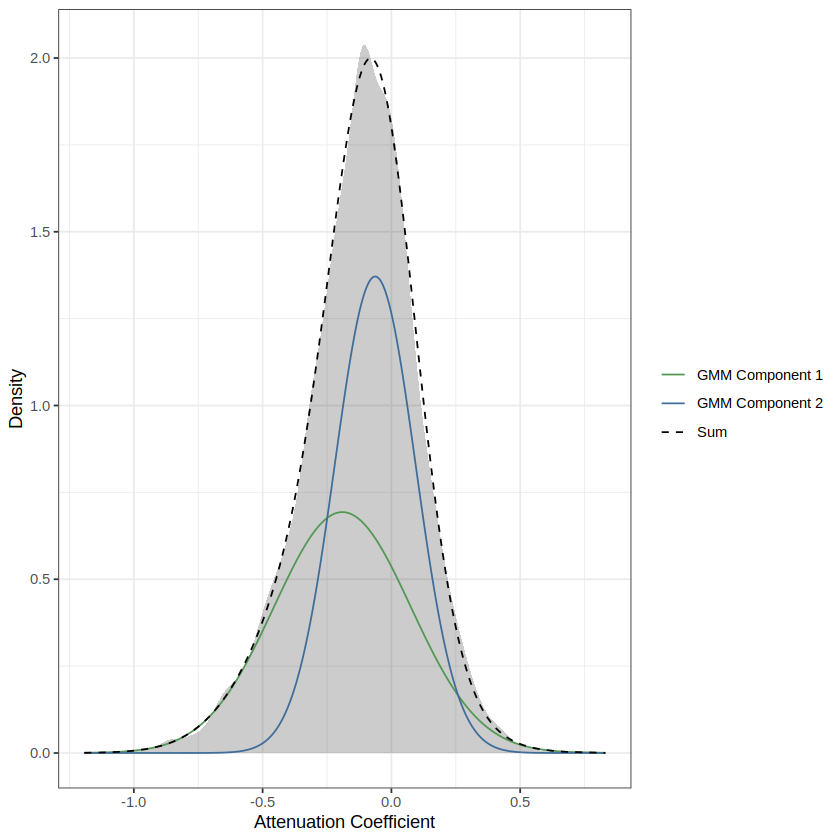

In [12]:
# Density from first component

gmm_density_1 <- gmm$parameters$pro[1] * dnorm(
    x = cnaCorDF$attenuation_coefficient, 
    mean = gmm$parameters$mean[1], 
    sd = sqrt(gmm$parameters$variance$sigmasq[1])
)

# Density from second component

gmm_density_2 <- gmm$parameters$pro[2] * dnorm(
    x = cnaCorDF$attenuation_coefficient, 
    mean = gmm$parameters$mean[2], 
    sd = sqrt(gmm$parameters$variance$sigmasq[2])
)

# Sum

gmm_density_sum <- gmm_density_1 + gmm_density_2


# Gather densities in a data frame

plotDF <- data.frame(
    x = c(
        rep(
            x = cnaCorDF$attenuation_coefficient,
            3
        )
    ),
    y = c(
        gmm_density_1,
        gmm_density_2,
        gmm_density_sum
    ),
    category = factor(
        x = c(rep("GMM Component 1", nrow(cnaCorDF)), rep("GMM Component 2", nrow(cnaCorDF)), rep("Sum", nrow(cnaCorDF))),
        levels = c("GMM Component 1", "GMM Component 2", "Sum")
    )
)

# Build overlayed density plot

ggplot() +
    geom_density(
        data = cnaCorDF,
        mapping = aes(
            x = attenuation_coefficient
        ),
        fill = "black",
        col = NA,
        alpha = 0.2
    ) +
    geom_line(
        data = plotDF,
        mapping = aes(
            x = x,
            y = y,
            col = category,
            linetype = category
        )
    ) +
    scale_x_continuous(
        name = "Attenuation Coefficient"
    ) +
    scale_y_continuous(
        name = "Density"
    ) +
    scale_color_manual(
        values = c(
            scico(
                n = 2,
                palette = "cork",
                begin = 0.2,
                end = 0.8,
                direction = -1
            ),
            "black"
        )
    ) +
    scale_linetype_manual(
        values = c(
            "solid",
            "solid",
            "dashed"
        )
    ) +
    theme(
        legend.title = element_blank()
    )

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#which-component-represents-the-attenuated-distribution-how-can-we-classify-cnas-based-on-these-distributions) Which component represents the attenuated distribution? How can we classify CNAs based on these distributions?

##### 💬 What do you think of the quality of the modelling?

In the following, we use the cumulative distribution function of the second component to scale the attenuation coefficient, and use the biologists' favorite threshold of 0.05 to highlight the confidently attenuated CNAs.

##### 👨‍💻 Scale the attenuation coefficient, threshold at 0.05, and plot on top of the distributions.

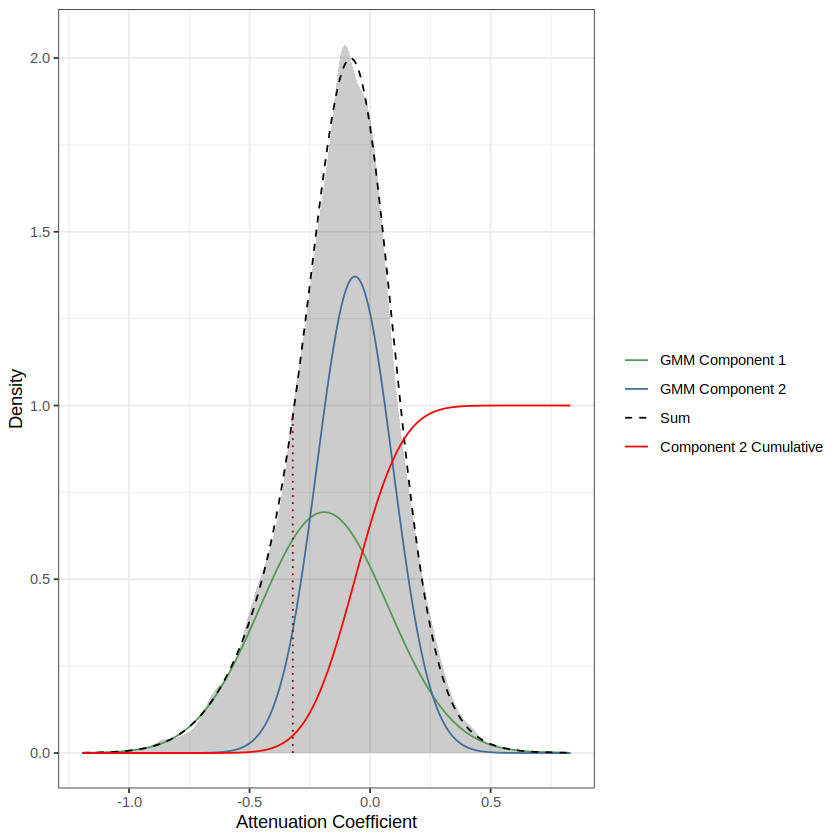

In [13]:
# Scale the attenuation coefficient

cnaCorDF$attenuation_p <- pnorm(
    q = cnaCorDF$attenuation_coefficient,
    mean = gmm$parameters$mean[2],
    sd = sqrt(gmm$parameters$variance$sigmasq[2])
)


# Threshold at 0.05

cnaCorDF$attenuation_category <- factor(
    x = ifelse(cnaCorDF$attenuation_p <= 0.05, "Attenuated", "Background"),
    levels = c("Attenuated", "Background")
)


# Gather densities in a data frame

plotDF <- data.frame(
    x = c(
        rep(
            x = cnaCorDF$attenuation_coefficient,
            4
        )
    ),
    y = c(
        gmm_density_1,
        gmm_density_2,
        gmm_density_sum,
        cnaCorDF$attenuation_p
    ),
    category = factor(
        x = c(rep("GMM Component 1", nrow(cnaCorDF)), rep("GMM Component 2", nrow(cnaCorDF)), rep("Sum", nrow(cnaCorDF)), rep("Component 2 Cumulative", nrow(cnaCorDF))),
        levels = c("GMM Component 1", "GMM Component 2", "Sum", "Component 2 Cumulative")
    )
)

# Build overlayed density plot

xThreshold <- qnorm(
    p = 0.05,
    mean = gmm$parameters$mean[2],
    sd = sqrt(gmm$parameters$variance$sigmasq[2])
)
yThreshold <- gmm$parameters$pro[1] * dnorm(
    x = xThreshold, 
    mean = gmm$parameters$mean[1], 
    sd = sqrt(gmm$parameters$variance$sigmasq[1])
) +  gmm$parameters$pro[2] * dnorm(
    x = xThreshold, 
    mean = gmm$parameters$mean[2], 
    sd = sqrt(gmm$parameters$variance$sigmasq[2])
)

ggplot() +
    geom_density(
        data = cnaCorDF,
        mapping = aes(
            x = attenuation_coefficient
        ),
        fill = "black",
        col = NA,
        alpha = 0.2
    ) +
    geom_line(
        data = plotDF,
        mapping = aes(
            x = x,
            y = y,
            col = category,
            linetype = category
        )
    ) +
    geom_segment(
        mapping = aes(
            x = xThreshold,
            xend = xThreshold,
            y = 0,
            yend = yThreshold
        ),
        linetype = "dotted",
        col = "darkred"
    ) +
    scale_x_continuous(
        name = "Attenuation Coefficient"
    ) +
    scale_y_continuous(
        name = "Density"
    ) +
    scale_color_manual(
        values = c(
            scico(
                n = 2,
                palette = "cork",
                begin = 0.2,
                end = 0.8,
                direction = -1
            ),
            "black",
            "red"
        )
    ) +
    scale_linetype_manual(
        values = c(
            "solid",
            "solid",
            "dashed",
            "solid"
        )
    ) +
    theme(
        legend.title = element_blank()
    )

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#using-this-threshold-what-is-the-share-of-cnas-considered-attenuated-that-would-come-from-the-component-2-distribution-what-is-the-share-of-cnas-considered-not-attenuated-that-would-come-from-the-component-1-how-will-this-influence-the-analyses) Using this threshold: What is the share of CNAs considered attenuated that would come from the component 2 distribution? What is the share of CNAs considered not attenuated that would come from the component 1? How will this influence the analyses?

##### 👨‍💻 Annotate the scaled attenuation coefficient on the scatter plot.

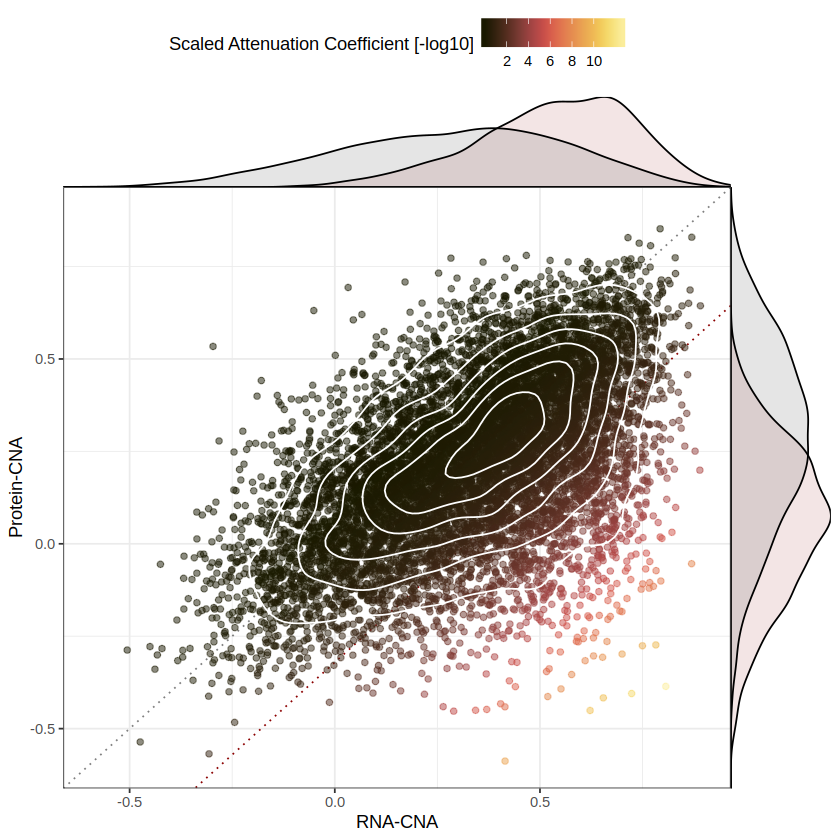

In [14]:
# Build the scatter plot with points colored by (logged) attenuation coefficient

axisMin <- min(c(cnaCorDF$mRNA_Spearman_correlation, cnaCorDF$protein_Spearman_correlation))
axisMax <- max(c(cnaCorDF$mRNA_Spearman_correlation, cnaCorDF$protein_Spearman_correlation))

cnaCorDF <- cnaCorDF %>%
    arrange(
        desc(attenuation_p)
    )

scatterPlot <- ggplot(
    data = cnaCorDF
) +
    geom_abline(
        slope = 1,
        intercept = 0,
        linetype = "dotted",
        col = "black",
        alpha = 0.5
    ) +
    geom_abline(
        slope = 1,
        intercept = xThreshold,
        color = "darkred",
        linetype = "dotted"
    ) +
    geom_point(
        mapping = aes(
            x = mRNA_Spearman_correlation,
            y = protein_Spearman_correlation,
            col = -log10(attenuation_p)
        ),
        alpha = 0.5
    ) +
    geom_density_2d(
        mapping = aes(
            x = mRNA_Spearman_correlation,
            y = protein_Spearman_correlation
        ),
        col = "white",
    ) +
    scale_color_scico(
        name = "Scaled Attenuation Coefficient [-log10]",
        palette = "lajolla",
        direction = -1,
        begin = 0.1,
        breaks = seq(0, 10, 2)
    ) +
    scale_x_continuous(
        name = "RNA-CNA",
        limits = c(axisMin, axisMax)
    ) +
    scale_y_continuous(
        name = "Protein-CNA",
        limits = c(axisMin, axisMax)
    ) +
    theme(
        legend.position = "top"
    )


# Build the density plots separating the points passing the attenuation threshold

rnaDensityPlot <- ggplot(
    data = cnaCorDF
) + theme_minimal() + 
    geom_density(
        mapping = aes(
            x = mRNA_Spearman_correlation,
            fill = attenuation_category
        ),
        alpha = 0.1
    ) +
    scale_fill_manual(
        values = c("darkred", "black")
    ) +
    scale_x_continuous(
        expand = c(0, 0)
    ) +
    scale_y_continuous(
        expand = c(0, 0)
    ) +
    theme(
        legend.position = "none",
        axis.title = element_blank(),
        axis.text = element_blank(),
        panel.grid = element_blank()
    )

proteinDensityPlot <- ggplot(
    data = cnaCorDF
) + theme_minimal() + 
    geom_density(
        mapping = aes(
            x = protein_Spearman_correlation,
            fill = attenuation_category
        ),
        alpha = 0.1
    ) +
    scale_fill_manual(
        values = c("darkred", "black")
    ) +
    scale_x_continuous(
        expand = c(0, 0)
    ) +
    scale_y_continuous(
        expand = c(0, 0)
    ) +
    theme(
        legend.position = "none",
        axis.title = element_blank(),
        axis.text = element_blank(),
        panel.grid = element_blank()
    ) + 
    coord_flip()


# Make grobs from plots

scatterGrob <- ggplotGrob(scatterPlot)
rnaDensityGrob <- ggplotGrob(rnaDensityPlot)
proteinDensityGrob <- ggplotGrob(proteinDensityPlot)


# Insert the densities as new row and column in the scatter grob

mergedGrob <- rbind(scatterGrob[1:8, ], rnaDensityGrob[7, ], scatterGrob[9:nrow(scatterGrob), ], size = "last")
mergedGrob$heights[9] <- unit(0.15, "null")

proteinDensityGrob <- gtable_add_rows(
    x = proteinDensityGrob, 
    heights = unit(rep(0, nrow(mergedGrob) - nrow(proteinDensityGrob)), "null"), 
    pos = 0
)

mergedGrob <- cbind(mergedGrob[, 1:5], proteinDensityGrob[, 5], mergedGrob[, 6:ncol(mergedGrob)], size = "first")
mergedGrob$widths[6] <- unit(0.15, "null")


# Plot

grid.draw(mergedGrob)

## Attenuation association with participation in complexes and biochemical reactions

One of the proposed mechanisms of CNA attenuation is that cells regulate the protein abundance through regulation of translation and protein degradation. In particular the abundance of proteins involved in complexes or biochemical reactions might be regulated to respect the stoichiometry required by the complex or reaction, and the proteins remaining in excess are degraded [(3)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references). 

To inspect this, we are now going to compare the CNA attenuation evaluated previously with the involvement of proteins in complexes, biochemical reactions, and protein-protein interactions (PPI). For this, we will use complexes from the [Complex Portal](https://www.ebi.ac.uk/complexportal/home), biochemical reactions from the [Reactome Pathway Database](https://reactome.org/), and PPIs from the [String database](https://string-db.org/). Pairs of interacting proteins from each databases were extracted in R-friendly format and are availabe in [resources/data/complexes.03.11.19.tsv.gz](resources/data/complexes.03.11.19.tsv.gz), [resources/data/proteinInternalEdges.tsv.gz](resources/data/proteinInternalEdges.tsv.gz), [resources/data/search.tsv.gz](resources/data/search.tsv.gz), and [resources/data/string_v10.5_high_edges.gz](resources/data/string_v10.5_high_edges.gz).

##### 👨‍💻  Load complex, reaction, and interaction data. Build corresponding biological networks, and plot the degree distribution of each network.

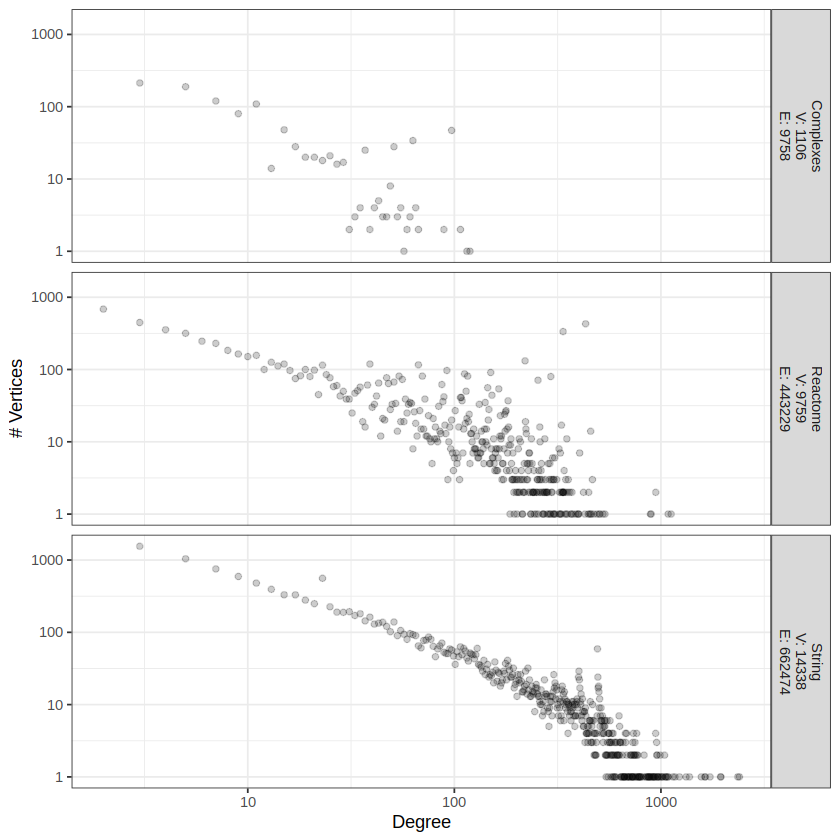

In [15]:
# Complexes

complexesDF <- read.table(
    file = "resources/data/complexes.03.11.19.tsv.gz", 
    header = T, 
    sep = "\t", 
    stringsAsFactors = F, 
    quote = "", 
    comment.char = ""
)


# Extract the protein to complex link, extract protein pairs involved in the same complex

complexesParticipantsList <- list()
complexesEdgesList <- list()

for (i in 1:nrow(complexesDF)) {
    
    complex <- complexesDF$complex_accession[i]
    participants <- complexesDF$participants_stoichiometry[i]
    
    proteinsSplit <- strsplit(
        x = participants,
        split = "\\|"
    )[[1]]
    participantsList <- strsplit(
        x = proteinsSplit,
        split = "[\\(\\)]"
    )
    
    participantsDF <- as.data.frame(
        t(
            unname(
                as.data.frame(
                    participantsList,
                    stringsAsFactors = F
                )
            )
        ),
        stringsAsFactors = F
    )
    names(participantsDF) <- c("protein", "stoichiometry")
    participantsDF$complex = complex
    
    complexesParticipantsList[[i]] <- participantsDF
    
    edgesDF <- data.frame(
        from = rep(participantsDF$protein, times = nrow(participantsDF)),
        to = rep(participantsDF$protein, each = nrow(participantsDF)),
        stringsAsFactors = F
    ) %>%
        filter(
            from != to
        ) %>%
        mutate(
            complex = complex
        )
    
    complexesEdgesList[[i]] <- edgesDF
    
}

complexesParticipantsDF <- do.call("rbind", complexesParticipantsList)
edgesComplexes <- do.call("rbind", complexesEdgesList)


# Protein reactions from Reactome

edgesReactome <- read.table(
    file = "resources/data/proteinInternalEdges.tsv.gz", 
    header = T, 
    sep = "\t", 
    stringsAsFactors = F, 
    quote = "", 
    comment.char = ""
)

reactomeSearchDF <- read.table(
    file = "resources/data/search.tsv.gz", 
    header = T, 
    sep = "\t", 
    stringsAsFactors = F, 
    quote = "", 
    comment.char = ""
)


# Protein interactions from String

edgesString <- read.table(
    file = "resources/data/string_v10.5_high_edges.gz", 
    header = T, 
    sep = " ", 
    stringsAsFactors = F, 
    quote = "", 
    comment.char = ""
)


# Build graphs

graphComplexes <- graph_from_data_frame(edgesComplexes)
graphReactome <- graph_from_data_frame(edgesReactome)
graphString <- graph_from_data_frame(edgesString)


# Simplify graphs

graphComplexes <- simplify(graphComplexes, remove.multiple = T, remove.loops = T, edge.attr.comb = "first")
graphReactome <- simplify(graphReactome, remove.multiple = T, remove.loops = T, edge.attr.comb = "first")
graphString <- simplify(graphString, remove.multiple = T, remove.loops = T, edge.attr.comb = "first")


# Extract degree distributions

degreeComplexes <- degree.distribution(graphComplexes) * length(V(graphComplexes))
degreeReactome <- degree.distribution(graphReactome) * length(V(graphReactome))
degreeString <- degree.distribution(graphString) * length(V(graphString))

complexLabel <- paste0("Complexes\nV: ", length(V(graphComplexes)), "\nE: ", length(E(graphComplexes)))
reactomeLabel <- paste0("Reactome\nV: ", length(V(graphReactome)), "\nE: ", length(E(graphReactome)))
stringLabel <- paste0("String\nV: ", length(V(graphString)), "\nE: ", length(E(graphString)))

degreeDF <- data.frame(
    degree = c(
        1:length(degreeComplexes), 
        1:length(degreeReactome), 
        1:length(degreeString)
    ),
    frequency = c(
        degreeComplexes, 
        degreeReactome, 
        degreeString
    ),
    graph = factor(
        c(
            rep(complexLabel, length(degreeComplexes)),
            rep(reactomeLabel, length(degreeReactome)),
            rep(stringLabel, length(degreeString))
        ),
        levels = c(complexLabel, reactomeLabel, stringLabel)
    )
) %>%
    filter(
        frequency > 0
    )


# Plot

ggplot(
    data = degreeDF
) +
    geom_point(
        mapping = aes(
            x = log10(degree),
            y = log10(frequency)
        ),
        alpha = 0.2
    ) +
    facet_grid(
        graph ~ .
    ) + scale_x_continuous(
        name = "Degree",
        breaks = 1:3,
        labels = 10^(1:3)
    ) + scale_y_continuous(
        name = "# Vertices",
        breaks = 0:3,
        labels = 10^(0:3)
    )

##### 💬 How does the degree distribution inform us on the structure of these networks?

These resources map interactions between proteins, yet the authors did not provide the accessions of the proteins associated to the CNAs. We therefore need to map the genes to proteins. For this, we will use the [UniProt](https://www.uniprot.org/) identifiers mapping. A mapping file for humans was downloaded in R-friendly format and is availabe in [resources/data/HUMAN_9606_idmapping.dat.gz](resources/data/HUMAN_9606_idmapping.dat.gz).

In [16]:
# Uniprot accession mapping

accessionsMapping <- read.table(
    file = "resources/data/HUMAN_9606_idmapping.dat.gz", 
    header = F, 
    sep = "\t", 
    quote = "", 
    comment.char = "", 
    stringsAsFactors = F
)
names(accessionsMapping) <- c("accession", "source", "gene")
accessionsMapping <- accessionsMapping %>%
    filter(
        source == "Gene_Name"
    ) %>%
    select (
        gene, accession
    ) %>%
    filter(
        gene %in% cnaCorDF$gene
    ) %>%
    distinct()

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#what-is-the-number-of-proteins-per-gene-reported-in-the-cna-table-how-is-this-going-to-influence-the-analysis) What is the number of proteins per gene reported in the CNA table? How is this going to influence the analysis?

Note that in the following, we exclude genes mapping to more than 100 proteins, and we use the sum of edges per protein for each gene.

In [17]:
# Exclude gene mapping with more than 10 proteins per gene

geneOccurenceDF <- as.data.frame(
    x = table(accessionsMapping$gene), 
    stringsAsFactors = F
)
names(geneOccurenceDF) <- c("gene", "nProteins")

excludedGenes <- geneOccurenceDF$gene[geneOccurenceDF$nProteins >= 100]

##### 👨‍💻 Plot the scaled CNA attenuation coefficient against the number of protein partners in the complex network

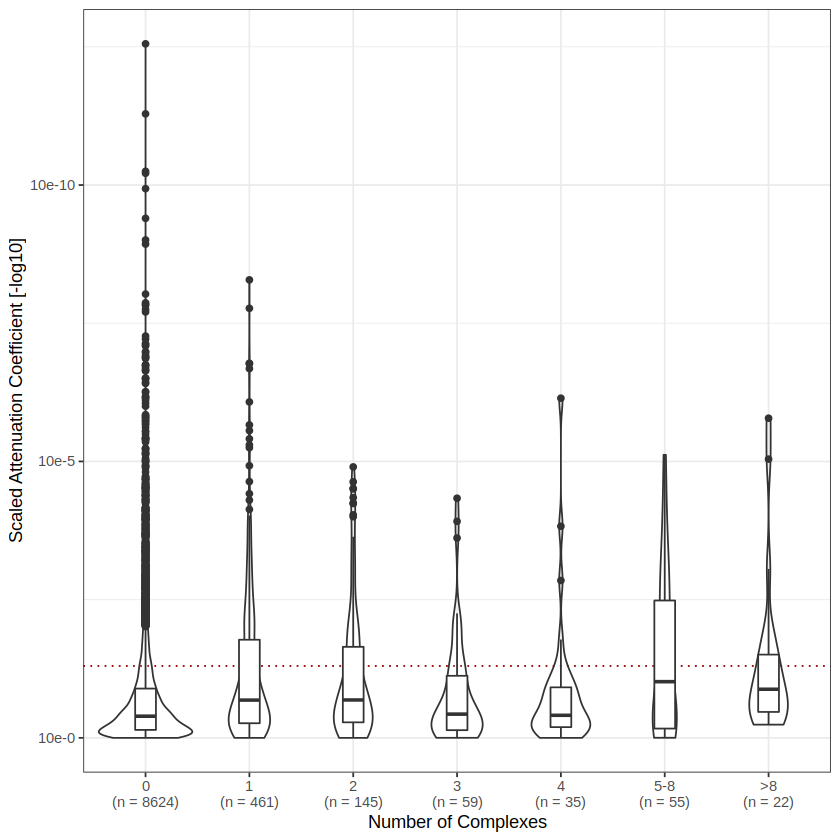

In [18]:
# Get the number of complexes per gene

nComplexesPerProteinDF <- complexesParticipantsDF %>%
    group_by(
        protein
    ) %>%
    summarise(
        n = n()
    ) %>%
    rename(
        accession = protein
    )

cnaComplexesDF <- accessionsMapping %>%
    filter(
        !gene %in% excludedGenes
    ) %>% 
    left_join(
        nComplexesPerProteinDF,
        by = "accession"
    ) %>%
    mutate(
        n = ifelse(is.na(n), 0, n)
    ) %>%
    select(
        -accession
    ) %>%
    distinct() %>%
    group_by(
        gene
    ) %>%
    summarise(
        n = sum(n)
    ) %>% 
    ungroup() %>%
    inner_join(
        cnaCorDF,
        by = "gene"
    )


# Build plot

cnaComplexesDF$nFactor <- factor(
    x = ifelse(cnaComplexesDF$n > 8, ">8", 
               ifelse(cnaComplexesDF$n > 4, "5-8", as.character(cnaComplexesDF$n))),
    levels = as.character(c(0:9, "5-8", ">8"))
)

levels <- levels(cnaComplexesDF$nFactor)

for (i in 1:length(levels)) {
    
    level <- levels[i]
    
    n <- sum(cnaComplexesDF$nFactor == level)
    
    level <- paste0(level, "\n(n = ", n, ")")
    
    levels[i] <- level
    
}

levels(cnaComplexesDF$nFactor) <- levels

ggplot(
    data = cnaComplexesDF
) +
    geom_hline(
        yintercept = -log10(0.05),
        color = "darkred",
        linetype = "dotted"
    ) +
    geom_violin(
        mapping = aes(
            x = nFactor,
            y = -log10(attenuation_p)
        ), 
        alpha = 0.1
    ) +
    geom_boxplot(
        mapping = aes(
            x = nFactor,
            y = -log10(attenuation_p)
        ),
        width = 0.2
    ) +
    scale_x_discrete(
        "Number of Complexes"
    ) +
    scale_y_continuous(
        "Scaled Attenuation Coefficient [-log10]",
        breaks = seq(0, 10, 5),
        labels = paste0("10e-", seq(0, 10, 5))
    )

##### 💬 According to this analysis, does the participation in complexes seem to be associated with CNA attenuation?


##### 👨‍💻 Plot the scaled CNA attenuation coefficient against the number of reactions in Reactome

Warning message:
“Removed 3704 rows containing non-finite values (stat_smooth).”

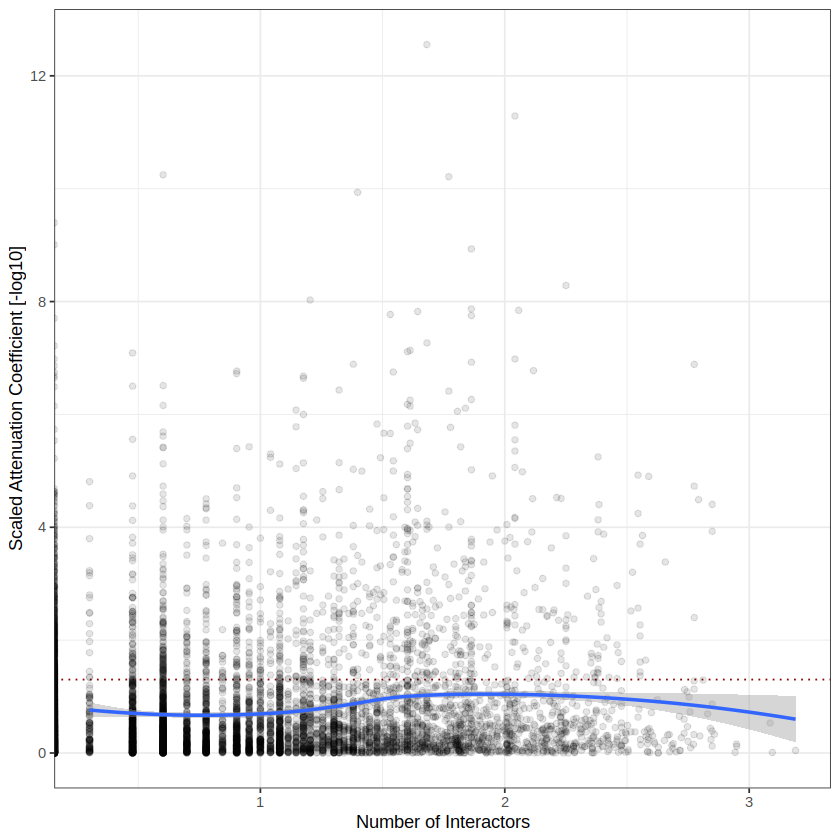

In [19]:
# Reactions per degree

nReactionsPerProteinDF <- reactomeSearchDF %>%
    select(
        UNIPROT, REACTION_STID
    ) %>%
    rename(
        protein = UNIPROT,
        reaction = REACTION_STID
    ) %>%
    group_by(
        protein
    ) %>%
    summarise(
        n = n()
    ) %>%
    rename(
        accession = protein
    )

cnaReactionsDF <- accessionsMapping %>%
    filter(
        !gene %in% excludedGenes
    ) %>% 
    left_join(
        nReactionsPerProteinDF,
        by = "accession"
    ) %>%
    mutate(
        n = ifelse(is.na(n), 0, n)
    ) %>%
    select(
        -accession
    ) %>%
    distinct() %>%
    group_by(
        gene
    ) %>%
    summarise(
        n = sum(n)
    ) %>% 
    ungroup() %>%
    inner_join(
        cnaCorDF,
        by = "gene"
    )


# Build plot

ggplot(
    data = cnaReactionsDF
) +
    geom_hline(
        yintercept = -log10(0.05),
        color = "darkred",
        linetype = "dotted"
    ) +
    geom_point(
        mapping = aes(
            x = log10(n),
            y = -log10(attenuation_p)
        ), 
        alpha = 0.1
    ) +
    geom_smooth(
        mapping = aes(
            x = log10(n),
            y = -log10(attenuation_p)
        ),
        method = "loess"
    ) +
    scale_x_continuous(
        "Number of Interactors"
    ) +
    scale_y_continuous(
        "Scaled Attenuation Coefficient [-log10]"
    )

##### 💬 According to this analysis, does the participation in biochemical reactions seem to be associated with CNA attenuation?


##### 👨‍💻 Plot the scaled CNA attenuation coefficient against the number of protein partners in the PPI network

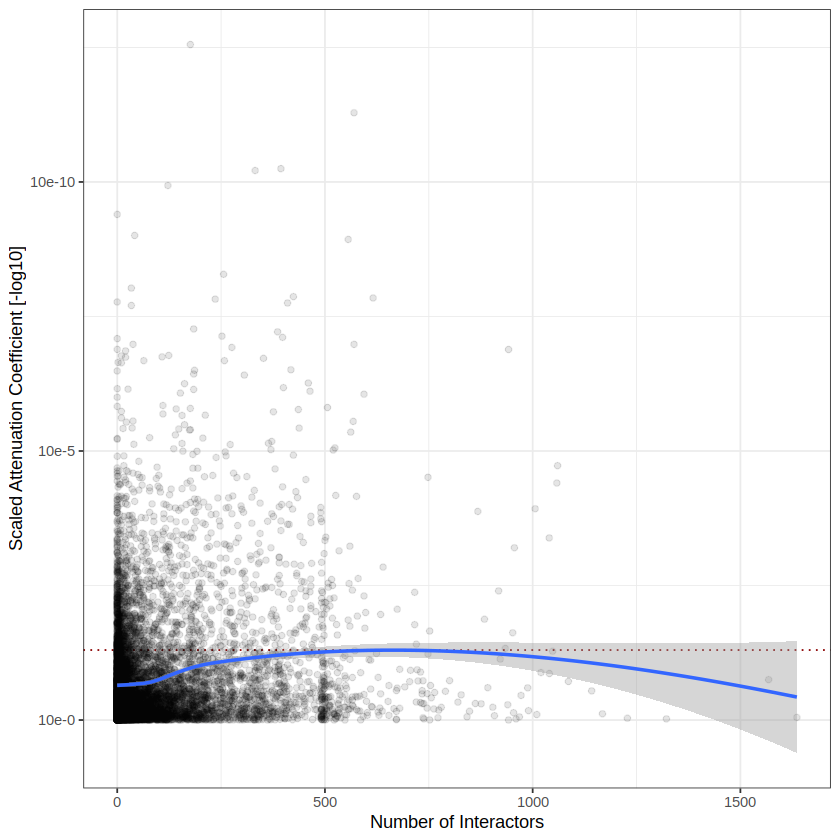

In [20]:
# Build degree data frame

degreeDF <- data.frame(
    accession = V(graphString)$name,
    degree = degree(graphString),
    stringsAsFactors = F
)

cnaDegreeDF <- accessionsMapping %>%
    filter(
        !gene %in% excludedGenes
    ) %>% 
    left_join(
        degreeDF,
        by = "accession"
    ) %>%
    mutate(
        degree = ifelse(is.na(degree), 0, degree)
    ) %>%
    select(
        -accession
    ) %>%
    distinct() %>%
    group_by(
        gene
    ) %>%
    summarise(
        degree = sum(degree)
    ) %>% 
    ungroup() %>%
    inner_join(
        cnaCorDF,
        by = "gene"
    )


# Build plot

ggplot(
    data = cnaDegreeDF
) +
    geom_hline(
        yintercept = -log10(0.05),
        color = "darkred",
        linetype = "dotted"
    ) +
    geom_point(
        mapping = aes(
            x = degree,
            y = -log10(attenuation_p)
        ), 
        alpha = 0.1
    ) +
    geom_smooth(
        mapping = aes(
            x = degree,
            y = -log10(attenuation_p)
        ),
        method = "loess"
    ) +
    scale_x_continuous(
        "Number of Interactors"
    ) +
    scale_y_continuous(
        "Scaled Attenuation Coefficient [-log10]",
        breaks = seq(0, 10, 5),
        labels = paste0("10e-", seq(0, 10, 5))
    )

##### 💬 According to this analysis, does the participation in PPIs seem to be associated with CNA attenuation? How does this relate to the participation in reactions?


## Conclusion

##### 💬 Can you speculate on the function or effect of CNA attenuation in cancer biology? How can these be used in a clinical setup?